## 1. Load data from csv file

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "https://www.dropbox.com/s/20yp4jzq7de0wzf/train.csv?dl=1"
)
print(df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [2]:
# Shuffling and dropping unnecessary columns
df_shuffled = df.sample(frac=1, random_state=42)

# Dropping id, keyword and location columns as these columns consists of mostly nan values
# we will be using only text and target columns
df_shuffled.drop(["id", "keyword", "location"], axis=1, inplace=True)
df_shuffled.reset_index(inplace=True, drop=True)
print(df_shuffled.head())

                                                text  target
0  So you have a new weapon that can cause un-ima...       1
1  The f$&amp;@ing things I do for #GISHWHES Just...       0
2  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1
3  Aftershock back to school kick off was great. ...       0
4  in response to trauma Children of Addicts deve...       0


In [3]:
test_df = df_shuffled.sample(frac=0.1, random_state=42)
train_df = df_shuffled.drop(test_df.index)
print(f"Using {len(train_df)} samples for training and {len(test_df)} for validation")

Using 6852 samples for training and 761 for validation


In [4]:
train_df = train_df.to_numpy()
test_df  = test_df.to_numpy()

## 2. Process data

### 2.1 Build vocab

In [5]:
# %pip install torchtext==0.12.0
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


english_tokenizer = get_tokenizer("basic_english")
vocab_size = 20000

def yield_tokens(data_iter):
    for data in data_iter:
        yield english_tokenizer(data[0])

vocab = build_vocab_from_iterator(yield_tokens(train_df),
                                  min_freq = 3,
                                  max_tokens=vocab_size,
                                  specials=["<pad>", "<s>", "</s>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

### 2.2 Buid dataset

In [6]:
import torch
from torch.utils.data import Dataset

class Tweets_Dataset(Dataset):
    def __init__(self, data, max_len, vocab, tokenizer):
        super().__init__()
        self.data = data
        self.max_len = max_len
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        text = self.data[idx][0]
        label = self.data[idx][1]

        text_processed = self.vocab(self.tokenizer(text))
        text_processed = text_processed[:self.max_len-2]
        text_processed = [vocab["<s>"]] + text_processed +  [vocab["</s>"]]

        if len(text_processed) < self.max_len:
            pad_size = self.max_len - len(text_processed)
            text_processed += [vocab["<pad>"]] * pad_size

        text_processed = torch.tensor(text_processed)
        label = torch.tensor(label)
        return {
            "input_ids": text_processed,
            "labels": label
        }

In [7]:
max_length = 200
train_data = Tweets_Dataset(train_df, max_length, vocab, english_tokenizer)
test_data = Tweets_Dataset(test_df, max_length, vocab, english_tokenizer)

### 2.3 Buid data loader

In [8]:
from torch.utils.data import DataLoader


batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## 3. Model

In [9]:
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.0, bias=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2


class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.pos_emb = nn.Embedding(num_embeddings=max_length, embedding_dim=embed_dim)

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x) 
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output


class TransformerTextCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device):
        super().__init__()
        self.embd_layer = TokenAndPositionEmbedding(vocab_size, embed_dim, max_length, device)
        self.transformer_layer = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output


In [10]:
embed_dim = 32
num_heads = 2
ff_dim = 32
dropout = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerTextCls(vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device)

## 4. Training

### 4.1 Eval function

In [11]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): 
        for batch in test_loader:
            inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

### 4.2 Train model

In [12]:
max_epoch = 40
LR = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [13]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for batch in train_loader:
        inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss =  running_loss / len(train_loader)
    epoch_accuracy = 100* running_correct / total
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/40], Loss: 0.6844, Accuracy: 56.61%, Test Loss: 0.6876, Test Accuracy: 54.27%
Epoch [2/40], Loss: 0.6805, Accuracy: 57.66%, Test Loss: 0.6817, Test Accuracy: 54.27%
Epoch [3/40], Loss: 0.6589, Accuracy: 60.96%, Test Loss: 0.6310, Test Accuracy: 64.65%
Epoch [4/40], Loss: 0.6021, Accuracy: 68.10%, Test Loss: 0.5697, Test Accuracy: 71.75%
Epoch [5/40], Loss: 0.5452, Accuracy: 73.56%, Test Loss: 0.5874, Test Accuracy: 72.01%
Epoch [6/40], Loss: 0.5252, Accuracy: 74.23%, Test Loss: 0.5565, Test Accuracy: 73.06%
Epoch [7/40], Loss: 0.5107, Accuracy: 76.09%, Test Loss: 0.5697, Test Accuracy: 72.54%
Epoch [8/40], Loss: 0.4938, Accuracy: 77.16%, Test Loss: 0.5450, Test Accuracy: 73.98%
Epoch [9/40], Loss: 0.4857, Accuracy: 77.76%, Test Loss: 0.5370, Test Accuracy: 74.24%
Epoch [10/40], Loss: 0.4771, Accuracy: 77.99%, Test Loss: 0.5365, Test Accuracy: 74.38%
Epoch [11/40], Loss: 0.4669, Accuracy: 78.74%, Test Loss: 0.5347, Test Accuracy: 74.77%
Epoch [12/40], Loss: 0.4542, Accuracy: 79

### 4.3 Plot the result

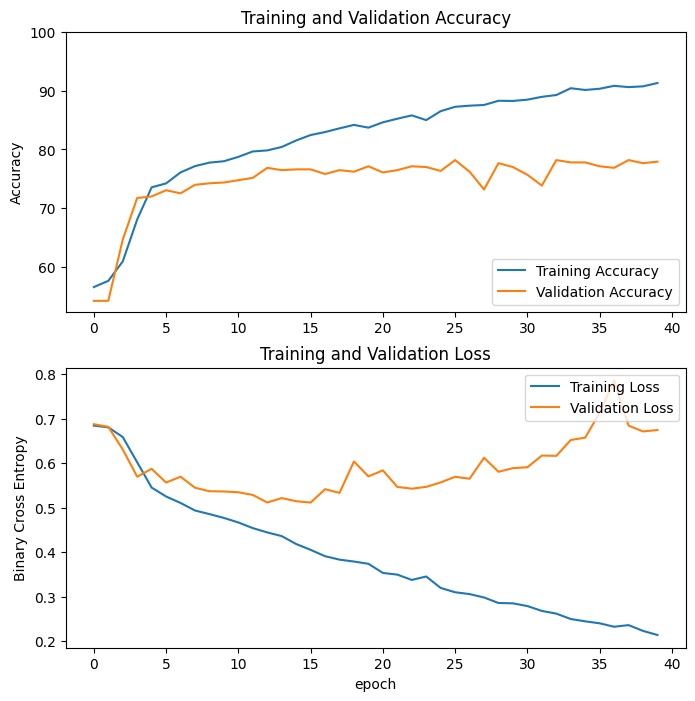

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()